#### This module will house the functions and code where we run models and try to get the highest R^squared/lowest RMSLE

In [202]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

In [235]:
#Import Data
final_df= pd.read_json('final_imputed.json')

In [236]:
#Train and Test Split
train=final_df[~final_df['year'].isin([2015,2016])]
test=final_df[final_df['year'].isin([2015,2016])]


#Predictor and Response
xtrain = train.loc[:,train.columns.difference(['violent_crime',
                                               'rape','robbery','assault', 'property', 'burglary', 'larceny','mv_theft'
                                               ,'rate_burglary', 'rate_larceny', 'rate_mur_mans', 'rate_mv_theft', 'rate_property', 'rate_rape', 'rate_robbery', 'rate_violent_crime'
                                               ,'city_mur_mans','mur_mans','state_key','join_key','MSA',
                                               'largest_city','rate_assault','city_key'])]
xtest = test.loc[:,test.columns.difference(['violent_crime',
                                            'rape','robbery','assault', 'property', 'burglary', 'larceny','mv_theft'
                                               ,'rate_burglary', 'rate_larceny', 'rate_mur_mans', 'rate_mv_theft', 'rate_property', 'rate_rape', 'rate_robbery', 'rate_violent_crime'                                    
                                            ,'city_mur_mans','mur_mans','state_key','join_key','MSA',
                                            'largest_city','rate_assault','city_key'])]

"""
xtrain=train[['msa_pop','year']]
xtest=test[['msa_pop','year']]
"""


ytrain=train['mur_mans']
ytest=test['mur_mans']

In [237]:
#Function for rolling window validation
#YET TO PENALIZE EVALUATION BY WINDOW SIZE
def rolling_window_evaluation(xtrain, xtest, ytrain, ytest, start_year, rolling_window_size, model):
    cv_rolling = []
    while start_year+rolling_window_size <=2013:
        filter=xtrain['year'].isin(range(start_year,start_year+rolling_window_size))
        
        xtrain_cv = xtrain[filter]
        ytrain_cv = ytrain[filter]
        
        xval_cv = xtrain[~filter]
        yval_cv = ytrain[~filter]
        
        model.fit(xtrain_cv,ytrain_cv)
        cv_rolling.append(model.score(xval_cv,yval_cv))
        rolling_window_size += 1
    return(np.mean(cv_rolling))   

In [238]:
#Yet to incorporate Decision Trees and Boosting
def all_model_evaluation(model_test,param_list):
    cv_scores=[]
    #Identify the best parameter
    for ele in param_list:
        cv_scores.append(rolling_window_evaluation(xtrain, xtest, ytrain, ytest, start_year=2006, rolling_window_size=3, model=model_test(alpha=ele)))
    best_param = param_list[np.argmax(cv_scores)]
    #Fit and evaluate the model with the best param
    model=Lasso(alpha = best_param)
    model.fit(xtrain,ytrain)
    return(model.score(xtest,ytest))

In [95]:
#Choice of the number of estimators for Random Forest
#Accuracy scores seem to plateau after 10
test = []
for ele in range(1,50):
    test.append(rolling_window_evaluation(xtrain, xtest, ytrain, ytest, start_year=2006, rolling_window_size=3, model=RandomForestRegressor(n_estimators=ele)))

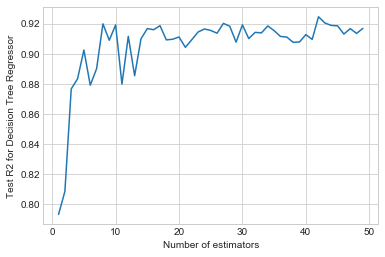

In [103]:
plt.plot(range(1,50),test)
plt.xlabel('Number of estimators')
plt.ylabel('Test R2 for Decision Tree Regressor');

In [242]:
all_model_evaluation(model_test=Lasso,param_list=[1e-5*(10)**ele for ele in range(1,6)])

0.95795963482344426

In [241]:
all_model_evaluation(model_test=Ridge,param_list=[1e-5*(10)**ele for ele in range(1,6)])

0.95371228511887107

In [240]:
rolling_window_evaluation(xtrain, xtest, ytrain, ytest, start_year=2006, rolling_window_size=3, model=RandomForestRegressor())

0.90544258156179747

In [239]:
rolling_window_evaluation(xtrain, xtest, ytrain, ytest, start_year=2006, rolling_window_size=3, model=KNeighborsRegressor())

0.87530162927863009